## Linear Regression Assignment
#### Model the demand for shared bikes

### Importing the necessary libraries

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
sns.set(rc={'figure.figsize':(12,10)})

### Reading the data

In [2]:
bike_df = pd.read_csv('day.csv')
bike_df.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Data exploration

In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### The dataset consists of 16 columns and 730 rows. There are no missing values.

There are only one column with **object** dtype, which is dteday. It will converted to date type.


In [4]:
bike_df['dteday']=pd.to_datetime(bike_df.dteday,dayfirst=True)

There are 7 categorical variables converted to numerical format.
We will be changing those values for better readability

In [5]:
bike_df['season'] = bike_df.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
bike_df['mnth'] = bike_df.mnth.map({1:'January', 2:'February', 3:'March', 4:'April',5:'May', 6:'June', 7:'July', 8:'August',9:'September', 10:'October', 11:'November', 12:'December'})
bike_df['weekday'] = bike_df.weekday.map({0:'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday'})
bike_df['weathersit'] = bike_df.weathersit.map({1:'Clear', 2:'Mist/Cloudy', 3:'Light Snow/ Rainy', 4:' Heavy Rainy/ Snow'})
bike_df['holiday'] = bike_df['holiday'].map({0:'no',1:'yes'})
bike_df['workingday'] = bike_df['workingday'].map({0:'no',1:'yes'})
bike_df['yr'] = bike_df['yr'].map({0:'2018',1:'2019'})

We have almost all the data that can ve derived from a date column provided to us.

### Univariate Analysis

In [6]:
bike_df.dtypes

instant                int64
dteday        datetime64[ns]
season                object
yr                    object
mnth                  object
holiday               object
weekday               object
workingday            object
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [7]:
num_cols = list(bike_df.select_dtypes(['int64','float64']).columns)
num_cols.remove('instant')

cat_cols = list(bike_df.select_dtypes('object').columns)

<Figure size 864x720 with 0 Axes>

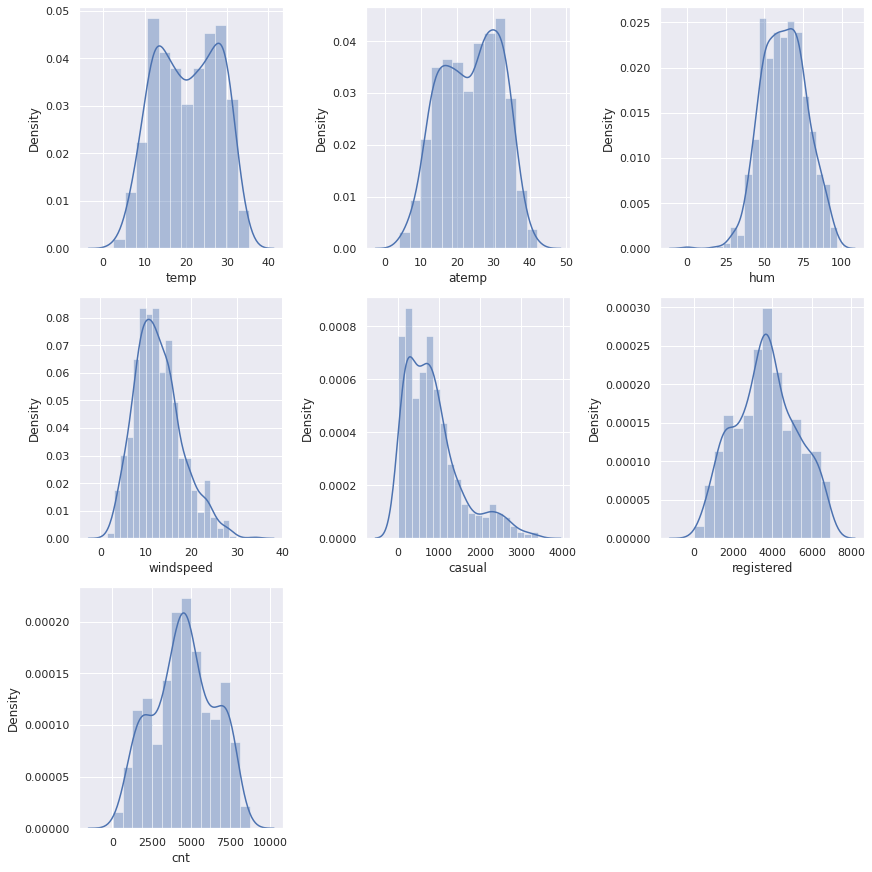

In [8]:
ncols = 3
nrows = math.ceil(len(num_cols)/3)
plt.subplots_adjust(hspace = 0.8)

fig,axes = plt.subplots(nrows, ncols, figsize=(12,12), constrained_layout=True)
i=0
j=0
for col in num_cols:
    sns.distplot(bike_df[col], ax=axes[i,j])
    j+=1
    if j>2:
        j=0
        i+=1
fig.delaxes(axes[2][1])
fig.delaxes(axes[2][2])

<Figure size 864x720 with 0 Axes>

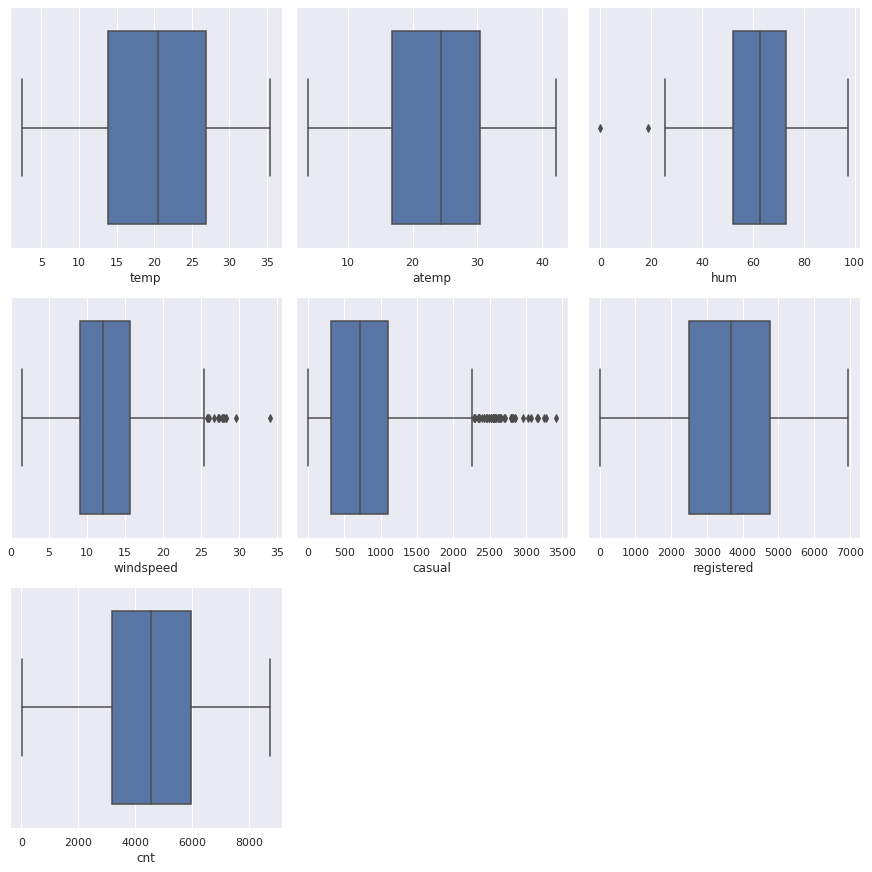

In [9]:
ncols = 3
nrows = math.ceil(len(num_cols)/3)
plt.subplots_adjust(hspace = 0.8)

fig,axes = plt.subplots(nrows, ncols, figsize=(12,12), constrained_layout=True)
i=0
j=0
for col in num_cols:
    sns.boxplot(bike_df[col], ax=axes[i,j])
    j+=1
    if j>2:
        j=0
        i+=1
fig.delaxes(axes[2][1])
fig.delaxes(axes[2][2])

<Figure size 864x720 with 0 Axes>

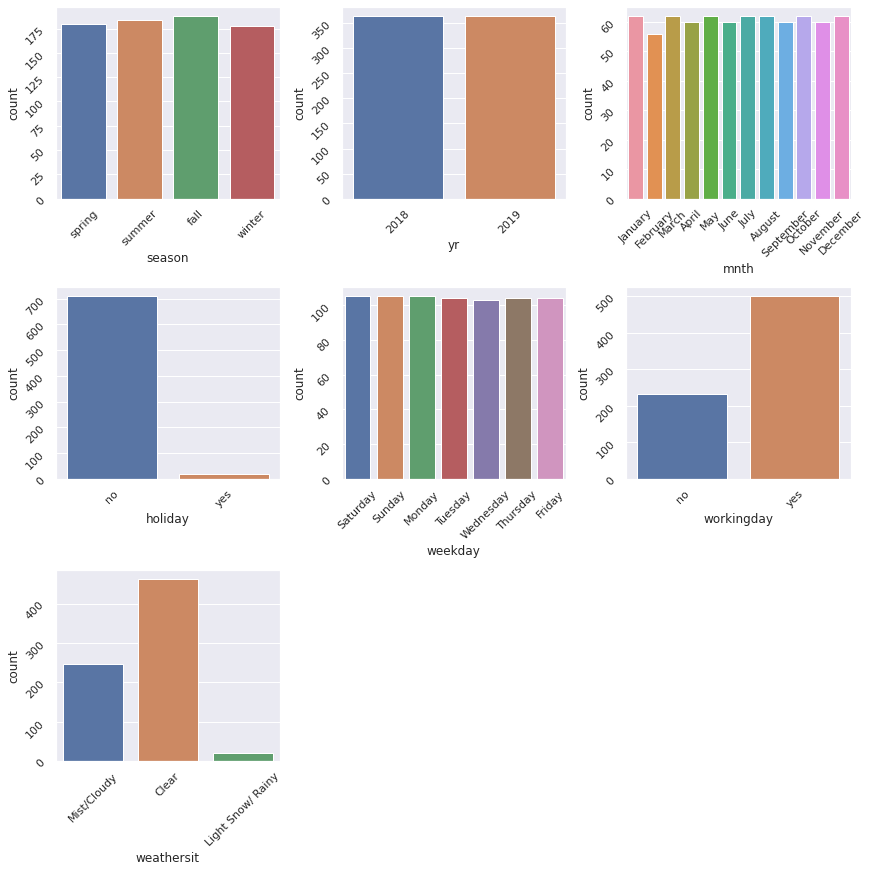

In [10]:
ncols = 3
nrows = math.ceil(len(cat_cols)/3)
plt.subplots_adjust(hspace = 0.8)

fig,axes = plt.subplots(nrows, ncols, figsize=(12,12), constrained_layout=True)
i=0
j=0
for col in cat_cols:
    sns.countplot(data=bike_df,x=col, ax=axes[i,j])
    axes[i,j].tick_params(labelrotation=45)
    j+=1
    if j>2:
        j=0
        i+=1
fig.delaxes(axes[2][1])
fig.delaxes(axes[2][2])

### Bivariate analysis

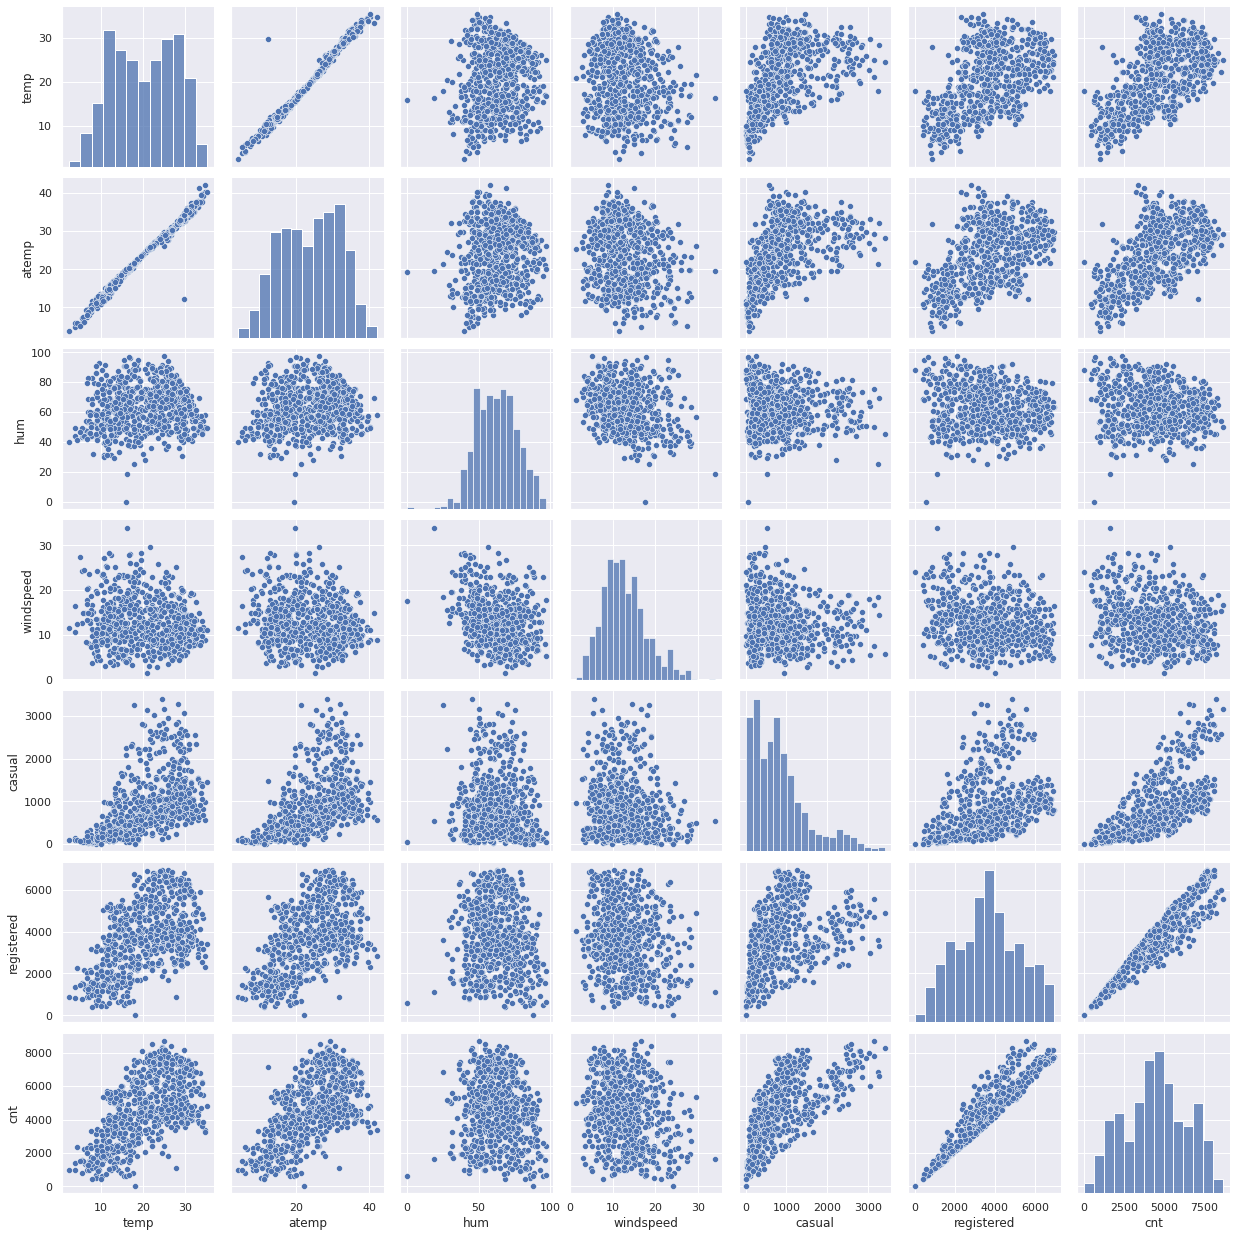

In [11]:
sns.pairplot(bike_df[num_cols])

Columns 'registered' and 'casual' sum up to 'cnt' and we can see a linear relationship between registered and cnt columns. We will be dropping registered and casual columns alongwith dteday and instant

In [12]:
bike_sharing = bike_df.drop(['instant','dteday','registered','casual'], axis=1)

<Figure size 864x720 with 0 Axes>

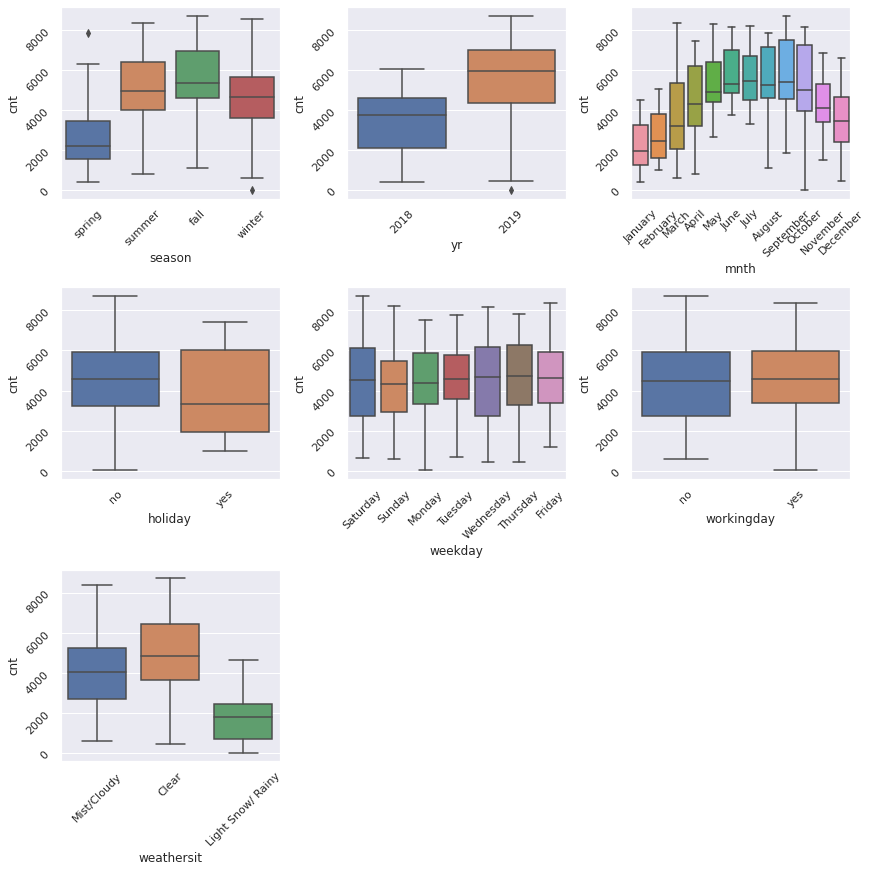

In [13]:
ncols = 3
nrows = math.ceil(len(cat_cols)/3)
plt.subplots_adjust(hspace = 0.8)

fig,axes = plt.subplots(nrows, ncols, figsize=(12,12), constrained_layout=True)
i=0
j=0
for col in cat_cols:
    p = sns.boxplot(data=bike_sharing,x=col,y='cnt',ax=axes[i,j])
    axes[i,j].tick_params(labelrotation=45)
    j+=1
    if j>2:
        j=0
        i+=1
        
fig.delaxes(axes[2][1])
fig.delaxes(axes[2][2])

### Observations
1. People tend to rent bikes during fall the most followed by summer.
2. Number of rented bike is higher in 2019
3. We see a increasing trend after April in bike sharing which ends in october
4. People share bikes more when there is no holiday
5. Number of bike sharing day-of-week wise seems to be similar
6. Bikes are rented when the weather is Clear / partly cloudy

<Figure size 864x720 with 0 Axes>

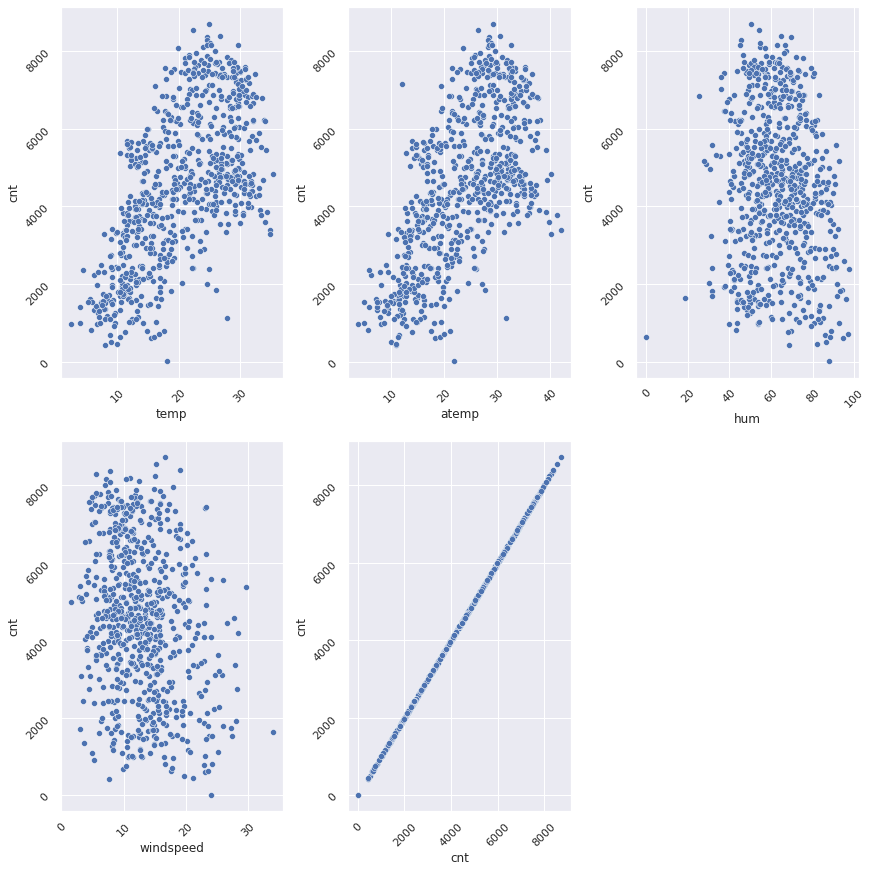

In [14]:
num_cols = list(bike_sharing.select_dtypes(['int64','float64']).columns)
ncols = 3
nrows = math.ceil(len(num_cols)/3)
plt.subplots_adjust(hspace = 0.8)

fig,axes = plt.subplots(nrows, ncols, figsize=(12,12), constrained_layout=True)
i=0
j=0
for col in num_cols:
    p = sns.scatterplot(data=bike_sharing,x=col,y='cnt',ax=axes[i,j])
    axes[i,j].tick_params(labelrotation=45)
    j+=1
    if j>2:
        j=0
        i+=1
        
fig.delaxes(axes[1][2])

Linear relationship can be found between temp and cnt

### Data handling

#### Encoding categorical data

The number possible values for weathersit is 4. In our dataset, only 3 of them appears. Those 3 can be represented with 2 dummy variables. But keeping the bigger picture in mind, it was decided not to use **drop_first=True** in case of **weathersit**.

In [15]:
dummy_cols = []
for col in cat_cols:
    if len(bike_sharing[col].unique())<=2:
        continue
    if col == 'weathersit':
        col_df = pd.get_dummies(bike_sharing[col])
    else:
        col_df = pd.get_dummies(bike_sharing[col], drop_first=True)
    bike_sharing = pd.concat([bike_sharing, col_df], axis=1)
    dummy_cols.append(col)

In [16]:
bike_sharing['holiday'] = bike_sharing['holiday'].map({'no':0,'yes':1})
bike_sharing['workingday'] = bike_sharing['workingday'].map({'no':0,'yes':1})
bike_sharing['yr'] = bike_sharing['yr'].map({'2018':0,'2019':1})

In [17]:
bike_sharing = bike_sharing.drop(dummy_cols,axis=1)

In [18]:
bike_sharing.head(10)

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,August,December,February,January,July,June,March,May,November,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Clear,Light Snow/ Rainy,Mist/Cloudy
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
5,0,0,1,8.378268,11.66045,51.8261,6.000868,1606,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
6,0,0,1,8.057402,10.44195,49.8696,11.304642,1510,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,6.765000,8.11270,53.5833,17.875868,959,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
8,0,0,0,5.671653,5.80875,43.4167,24.250650,822,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
9,0,0,1,6.184153,7.54440,48.2917,14.958889,1321,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [19]:
np.random.seed(0)
df_train, df_test = train_test_split(bike_sharing, train_size = 0.7, test_size = 0.3, random_state = 100)

In [20]:
scaler = MinMaxScaler()
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,August,December,February,January,July,June,March,May,November,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Clear,Light Snow/ Rainy,Mist/Cloudy
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


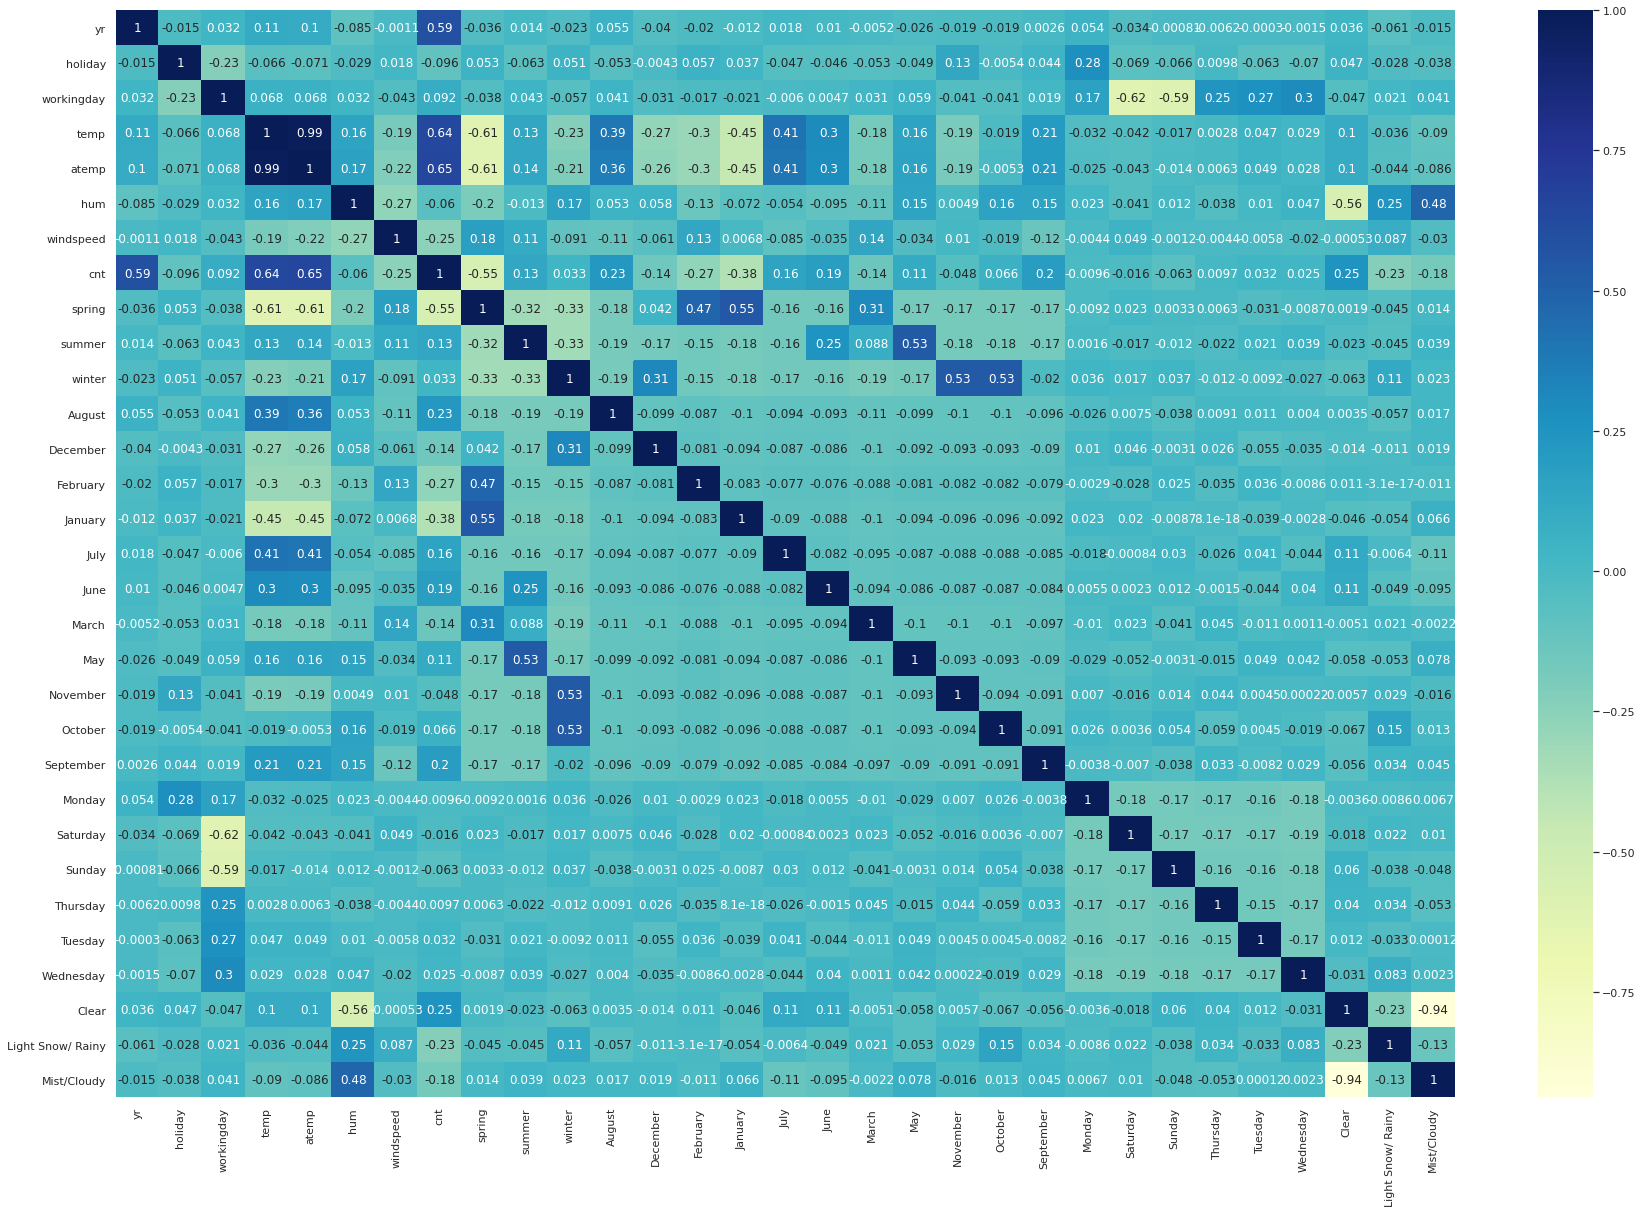

In [21]:
plt.figure(figsize = (30, 20))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

We see a correaltion between temp-cnt, atemp-cnt and yr-cnt

There is a very high correlation between temp and atemp

### Model Building

#### Assumptions

There's a linear relationship between X,y

#### Creating training label and features

In [22]:
y_train = df_train.pop('cnt')
X_train = df_train

<AxesSubplot:xlabel='temp', ylabel='cnt'>

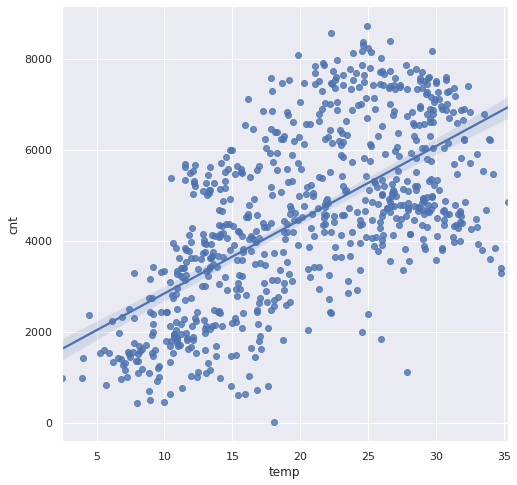

In [23]:
plt.figure(figsize=[8,8])
sns.regplot(data=bike_sharing, x='temp', y='cnt')

Assumption of linear Relationship between X and y is satisfied

#### Creating model with all the variables

In [24]:
X_train_lm = sm.add_constant(X_train)

lr_all = sm.OLS(y_train, X_train_lm).fit()

lr_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     99.96
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          8.42e-181
Time:                        19:15:18   Log-Likelihood:                 528.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     481   BIC:                            -875.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1267      0.030      4.290      0.000       0.069       0.185
yr                    0.2322      0.008     28.792      0.000       0.216       0.248
holiday              -0.0189      0.023     -0.811      0.418      -0.065       0.027
workingday            0.0673      0.011      5.911      0.000       0.045       0.090
temp                  0.4013      0.142      2.821      0.005       0.122       0.681
atemp                 0.0506      0.138      0.366      0.714      -0.221       0.322
hum                  -0.1518      0.039     -3.940      0.000      -0.228      -0.076
windspeed            -0.1844      0.026     -7.003      0.000      -0.236      -0.133
spring               -0.0486      0.030     -1.618      0.106      -0.108       0.010
summer                0.0382      0.026      1.455      0.146      -0.013       0.090
winter                0.1054      0.028      3.770      0.000       0.050       0.160
August                0.0161      0.034      0.473      0.637      -0.051       0.083
December             -0.0456      0.034     -1.356      0.176      -0.112       0.020
February             -0.0322      0.033     -0.978      0.329      -0.097       0.032
January              -0.0626      0.034     -1.864      0.063      -0.129       0.003
July                 -0.0393      0.035     -1.116      0.265      -0.108       0.030
June                 -0.0017      0.025     -0.067      0.946      -0.051       0.048
March                 0.0013      0.025      0.052      0.958      -0.047       0.050
May                   0.0247      0.021      1.169      0.243      -0.017       0.066
November             -0.0418      0.036     -1.149      0.251      -0.113       0.030
October               0.0077      0.036      0.215      0.830      -0.063       0.078
September             0.0818      0.032      2.549      0.011       0.019       0.145
Monday               -0.0215      0.015     -1.395      0.164      -0.052       0.009
Saturday              0.0664      0.013      5.113      0.000       0.041       0.092
Sunday                0.0119      0.013      0.891      0.373      -0.014       0.038
Thursday             -0.0097      0.016     -0.625      0.532      -0.040       0.021
Tuesday              -0.0193      0.016     -1.242      0.215      -0.050       0.011
Wednesday            -0.0057      0.015     -0.384      0.701      -0.035       0.024
Clear                 0.1481      0.012     12.877      0.000       0.126       0.171
Light Snow/ Rainy    -0.1085      0.022     -4.991      0.000      -0.151      -0.066
Mist/Cloudy           0.0871      0.013      6.807      0.000       0.062       0.112
==============================================================================
Omnibus:                       85.143   Durbin-Watson:                   2.041
P

This model with all the variable will work as a benchmark for us. 

Now we can start removing variables which are insignificant / correlated to other variables

Text(0.5, 0, 'Errors')

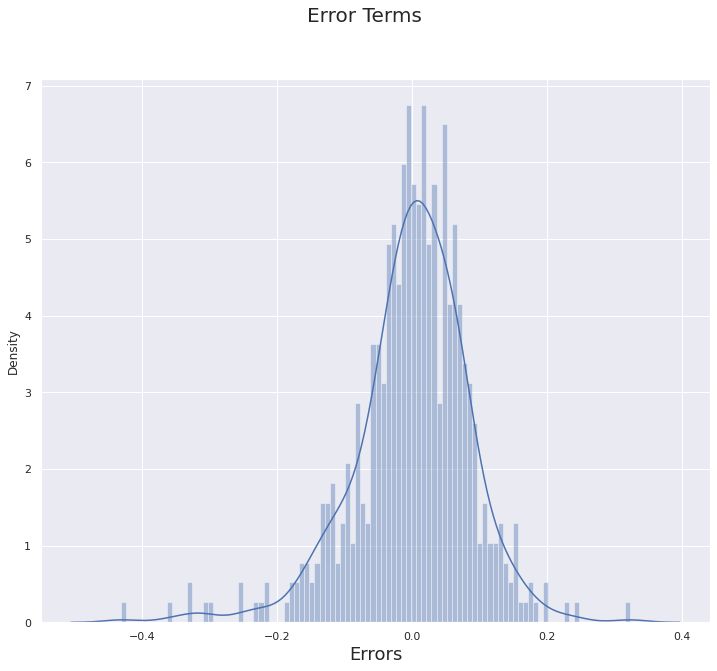

In [25]:
y_train_cnt = lr_all.predict(X_train_lm)
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 100)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

In [26]:
round((y_train - y_train_cnt).mean())

0

Error terms are normally distributed

Mean of error terms is zero (0).

#### Feature selection

In [27]:
lr = LinearRegression()
selector = RFE(lr, n_features_to_select=15, step=1)
selector = selector.fit(X_train,y_train)

In [28]:
for col_details in zip(X_train.columns,selector.support_, selector.ranking_):
    print(col_details)

('yr', True, 1)
('holiday', False, 4)
('workingday', True, 1)
('temp', True, 1)
('atemp', False, 11)
('hum', True, 1)
('windspeed', True, 1)
('spring', True, 1)
('summer', False, 12)
('winter', True, 1)
('August', True, 1)
('December', False, 2)
('February', False, 5)
('January', False, 3)
('July', True, 1)
('June', True, 1)
('March', False, 7)
('May', False, 13)
('November', True, 1)
('October', False, 6)
('September', False, 15)
('Monday', False, 9)
('Saturday', True, 1)
('Sunday', False, 8)
('Thursday', False, 16)
('Tuesday', False, 10)
('Wednesday', False, 14)
('Clear', True, 1)
('Light Snow/ Rainy', True, 1)
('Mist/Cloudy', True, 1)


In [29]:
X_train_selected = X_train.loc[:,selector.support_]

In [30]:
X_train_lm = sm.add_constant(X_train_selected)

lr_1 = sm.OLS(y_train, X_train_lm).fit()
lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     192.2
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          9.67e-190
Time:                        19:15:18   Log-Likelihood:                 513.26
No. Observations:                 510   AIC:                            -996.5
Df Residuals:                     495   BIC:                            -933.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1364      0.028      4.908      0.000       0.082       0.191
yr                    0.2292      0.008     28.316      0.000       0.213       0.245
workingday            0.0511      0.011      4.672      0.000       0.030       0.073
temp                  0.5591      0.035     15.986      0.000       0.490       0.628
hum                  -0.1678      0.038     -4.398      0.000      -0.243      -0.093
windspeed            -0.1856      0.026     -7.272      0.000      -0.236      -0.135
spring               -0.1107      0.015     -7.445      0.000      -0.140      -0.081
winter                0.0583      0.013      4.325      0.000       0.032       0.085
August               -0.0640      0.017     -3.796      0.000      -0.097      -0.031
July                 -0.1255      0.019     -6.542      0.000      -0.163      -0.088
June                 -0.0544      0.018     -3.006      0.003      -0.090      -0.019
November             -0.0332      0.017     -1.946      0.052      -0.067       0.000
Saturday              0.0629      0.014      4.458      0.000       0.035       0.091
Clear                 0.1465      0.010     15.378      0.000       0.128       0.165
Light Snow/ Rainy    -0.1002      0.022     -4.502      0.000      -0.144      -0.056
Mist/Cloudy           0.0900      0.012      7.496      0.000       0.066       0.114
==============================================================================
Omnibus:                       73.144   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.273
Skew:                          -0.723   Prob(JB):                     1.31e-41
Kurtosis:                       5.602   Cond. No.                     1.24e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.09e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [31]:
def get_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [32]:
get_vif(X_train_selected)

,Features,VIF
12,Clear,42.29
14,Mist/Cloudy,29.31
13,Light Snow/ Rainy,4.05
2,temp,3.94
5,spring,2.57
6,winter,2.15
3,hum,1.96
1,workingday,1.66
11,Saturday,1.65
8,July,1.64


Removing **November** as it is Insignificant (P>|t|)>0.05

In [33]:
X2 = X_train_selected.drop(['November'],axis=1)
X_train_lm = sm.add_constant(X2)

lr_2 = sm.OLS(y_train, X_train_lm).fit()
lr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.5
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          4.33e-190
Time:                        19:15:19   Log-Likelihood:                 511.32
No. Observations:                 510   AIC:                            -994.6
Df Residuals:                     496   BIC:                            -935.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1313      0.028      4.733      0.000       0.077       0.186
yr                    0.2292      0.008     28.239      0.000       0.213       0.245
workingday            0.0518      0.011      4.729      0.000       0.030       0.073
temp                  0.5683      0.035     16.351      0.000       0.500       0.637
hum                  -0.1650      0.038     -4.316      0.000      -0.240      -0.090
windspeed            -0.1880      0.026     -7.354      0.000      -0.238      -0.138
spring               -0.1077      0.015     -7.263      0.000      -0.137      -0.079
winter                0.0479      0.012      3.860      0.000       0.024       0.072
August               -0.0662      0.017     -3.924      0.000      -0.099      -0.033
July                 -0.1279      0.019     -6.666      0.000      -0.166      -0.090
June                 -0.0559      0.018     -3.086      0.002      -0.092      -0.020
Saturday              0.0644      0.014      4.555      0.000       0.037       0.092
Clear                 0.1443      0.009     15.212      0.000       0.126       0.163
Light Snow/ Rainy    -0.1010      0.022     -4.526      0.000      -0.145      -0.057
Mist/Cloudy           0.0880      0.012      7.337      0.000       0.064       0.112
==============================================================================
Omnibus:                       72.644   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.380
Skew:                          -0.719   Prob(JB):                     3.37e-41
Kurtosis:                       5.589   Cond. No.                     1.19e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.17e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [34]:
get_vif(X2)

,Features,VIF
11,Clear,41.73
13,Mist/Cloudy,29.02
12,Light Snow/ Rainy,4.03
2,temp,3.87
5,spring,2.55
3,hum,1.95
6,winter,1.81
1,workingday,1.65
8,July,1.64
10,Saturday,1.64


Removing **Clear** as it's VIF value is way above 10

In [35]:
X3 = X2.drop(['Clear'],axis=1)
X_train_lm = sm.add_constant(X3)

lr_3 = sm.OLS(y_train, X_train_lm).fit()
lr_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.5
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          4.33e-190
Time:                        19:15:19   Log-Likelihood:                 511.32
No. Observations:                 510   AIC:                            -994.6
Df Residuals:                     496   BIC:                            -935.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2756      0.033      8.476      0.000       0.212       0.339
yr                    0.2292      0.008     28.239      0.000       0.213       0.245
workingday            0.0518      0.011      4.729      0.000       0.030       0.073
temp                  0.5683      0.035     16.351      0.000       0.500       0.637
hum                  -0.1650      0.038     -4.316      0.000      -0.240      -0.090
windspeed            -0.1880      0.026     -7.354      0.000      -0.238      -0.138
spring               -0.1077      0.015     -7.263      0.000      -0.137      -0.079
winter                0.0479      0.012      3.860      0.000       0.024       0.072
August               -0.0662      0.017     -3.924      0.000      -0.099      -0.033
July                 -0.1279      0.019     -6.666      0.000      -0.166      -0.090
June                 -0.0559      0.018     -3.086      0.002      -0.092      -0.020
Saturday              0.0644      0.014      4.555      0.000       0.037       0.092
Light Snow/ Rainy    -0.2453      0.026     -9.315      0.000      -0.297      -0.194
Mist/Cloudy          -0.0562      0.011     -5.337      0.000      -0.077      -0.036
==============================================================================
Omnibus:                       72.644   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.380
Skew:                          -0.719   Prob(JB):                     3.37e-41
Kurtosis:                       5.589   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
get_vif(X3)

,Features,VIF
3,hum,24.57
2,temp,21.69
1,workingday,4.63
4,windspeed,4.16
5,spring,2.59
12,Mist/Cloudy,2.24
6,winter,2.14
0,yr,2.07
10,Saturday,1.82
8,July,1.77


Removing **hum** as it's VIF value is way above 10

In [37]:
X4 = X3.drop(['hum'],axis=1)
X_train_lm = sm.add_constant(X4)

lr_4 = sm.OLS(y_train, X_train_lm).fit()
lr_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     213.5
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          2.61e-187
Time:                        19:15:19   Log-Likelihood:                 501.91
No. Observations:                 510   AIC:                            -977.8
Df Residuals:                     497   BIC:                            -922.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1870      0.026      7.288      0.000       0.137       0.237
yr                    0.2334      0.008     28.457      0.000       0.217       0.249
workingday            0.0547      0.011      4.913      0.000       0.033       0.077
temp                  0.5242      0.034     15.507      0.000       0.458       0.591
windspeed            -0.1552      0.025     -6.249      0.000      -0.204      -0.106
spring               -0.1117      0.015     -7.414      0.000      -0.141      -0.082
winter                0.0398      0.012      3.187      0.002       0.015       0.064
August               -0.0576      0.017     -3.378      0.001      -0.091      -0.024
July                 -0.1126      0.019     -5.869      0.000      -0.150      -0.075
June                 -0.0421      0.018     -2.320      0.021      -0.078      -0.006
Saturday              0.0686      0.014      4.785      0.000       0.040       0.097
Light Snow/ Rainy    -0.2900      0.025    -11.774      0.000      -0.338      -0.242
Mist/Cloudy          -0.0824      0.009     -9.390      0.000      -0.100      -0.065
==============================================================================
Omnibus:                       72.971   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.277
Skew:                          -0.726   Prob(JB):                     5.86e-41
Kurtosis:                       5.571   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
get_vif(X4)

,Features,VIF
2,temp,8.88
1,workingday,4.48
3,windspeed,4.16
0,yr,2.06
4,spring,1.84
9,Saturday,1.79
6,August,1.65
7,July,1.65
5,winter,1.62
11,Mist/Cloudy,1.56


Removing **temp** as it's VIF value is above 5. 

We are going to observe how the model performs when this variable is removed.

In [39]:
X5 = X4.drop(['temp'],axis=1)
X_train_lm = sm.add_constant(X5)

lr_5 = sm.OLS(y_train, X_train_lm).fit()
lr_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     142.5
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          5.07e-146
Time:                        19:15:19   Log-Likelihood:                 401.29
No. Observations:                 510   AIC:                            -778.6
Df Residuals:                     498   BIC:                            -727.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5010      0.019     26.148      0.000       0.463       0.539
yr                    0.2469      0.010     24.883      0.000       0.227       0.266
workingday            0.0562      0.014      4.146      0.000       0.030       0.083
windspeed            -0.1887      0.030     -6.268      0.000      -0.248      -0.130
spring               -0.2622      0.014    -18.718      0.000      -0.290      -0.235
winter               -0.0353      0.014     -2.526      0.012      -0.063      -0.008
August                0.0535      0.019      2.842      0.005       0.017       0.090
July                  0.0276      0.021      1.342      0.180      -0.013       0.068
June                  0.0558      0.021      2.692      0.007       0.015       0.096
Saturday              0.0622      0.017      3.566      0.000       0.028       0.097
Light Snow/ Rainy    -0.2869      0.030     -9.573      0.000      -0.346      -0.228
Mist/Cloudy          -0.0884      0.011     -8.285      0.000      -0.109      -0.067
==============================================================================
Omnibus:                       32.464   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.999
Skew:                          -0.355   Prob(JB):                     6.31e-16
Kurtosis:                       4.671   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
get_vif(X5)

,Features,VIF
2,windspeed,3.50
1,workingday,3.41
0,yr,1.91
3,spring,1.72
8,Saturday,1.61
4,winter,1.60
10,Mist/Cloudy,1.53
5,August,1.27
7,June,1.20
6,July,1.19


Dropping **temp** variable affects the model performance severely

The **F-statistic** dropped from 213.5 to 142.5

The **R-squared** value also reduced to 0.759 from 0.838


### Residual analysis

Mean of Error term:  0.0000000000


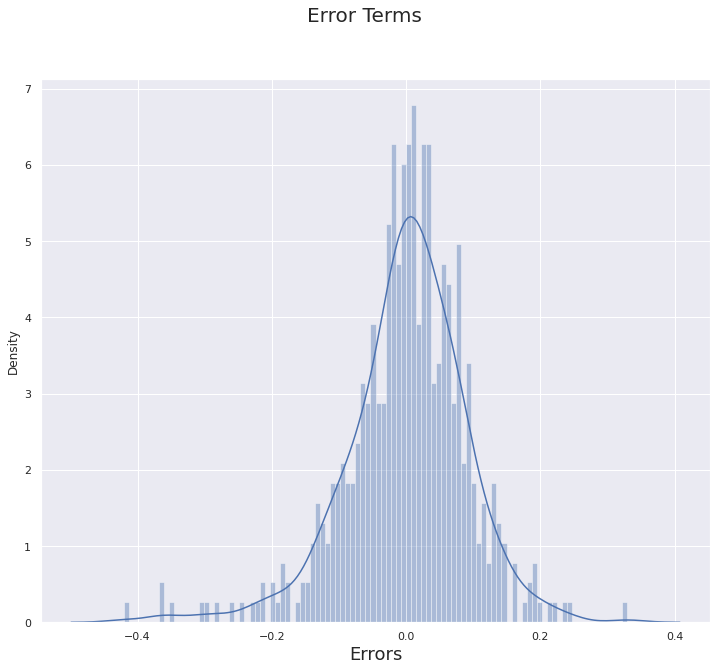

In [41]:
lr_4_cols = list(lr_4.cov_params().index)
lr_4_cols.remove('const')

X_train_final = X_train[lr_4_cols]
X_train_final_lm = sm.add_constant(X_train_final)

y_train_cnt = lr_4.predict(X_train_final_lm)
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 100)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)
print(f'Mean of Error term:  {(y_train-y_train_cnt).mean():.10f}')

(510,)

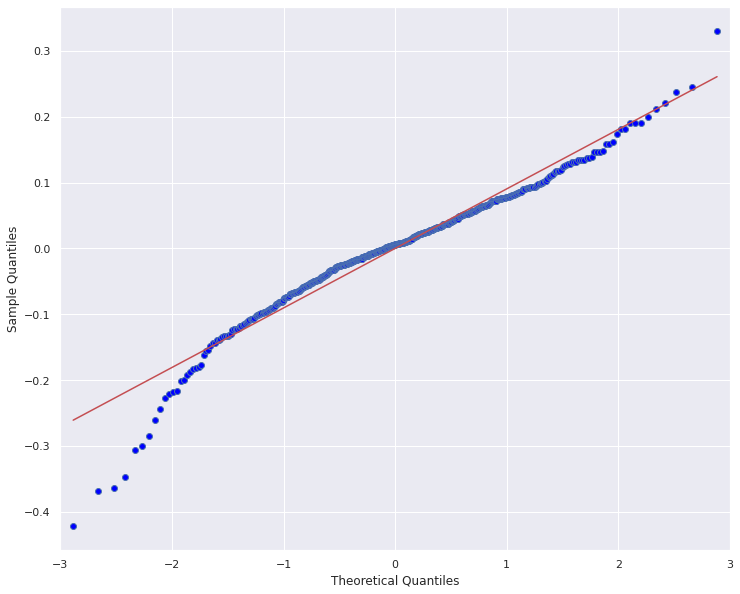

In [42]:
res = y_train.values - y_train_cnt.values
sm.qqplot(res, line = "s")
res.shape

#### The error terms are normally distributed with a mean of 0

Text(0, 0.5, 'Residual')

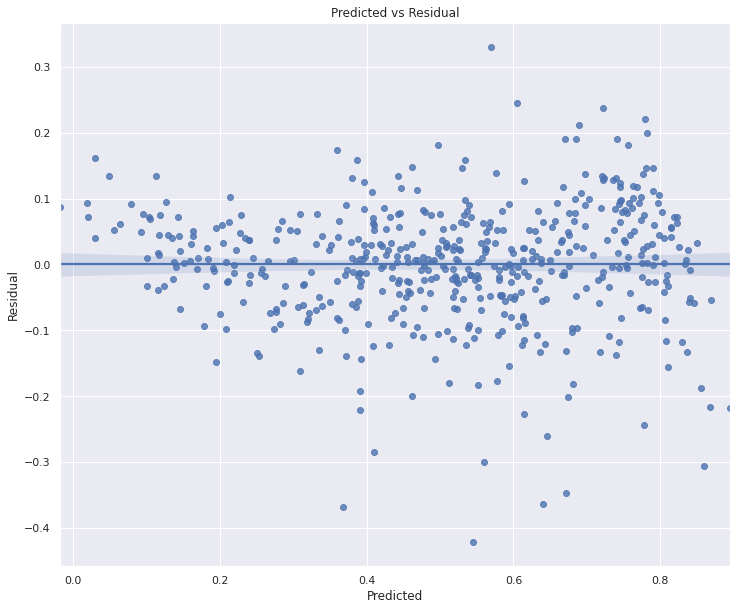

In [43]:
sns.regplot(x=y_train_cnt, y=(y_train-y_train_cnt))
plt.title('Predicted vs Residual')
plt.xlabel('Predicted')
plt.ylabel('Residual')

#### We can see that there are no dependecy between error terms

Text(0, 0.5, 'Actual')

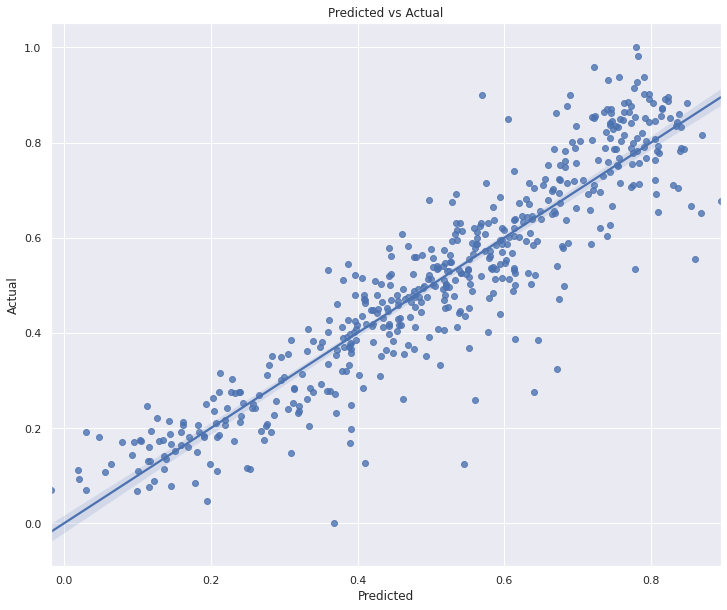

In [44]:
sns.regplot(x=y_train_cnt, y=y_train)
plt.title('Predicted vs Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#### The error terms seem to have constant variance

### Model Testing

Scaling the numerical data

In [45]:
df_test[num_cols] = scaler.transform(df_test[num_cols])

In [46]:
y_test = df_test.pop('cnt')

X_test = df_test[lr_4_cols]
X_test = sm.add_constant(X_test)


<AxesSubplot:xlabel='cnt'>

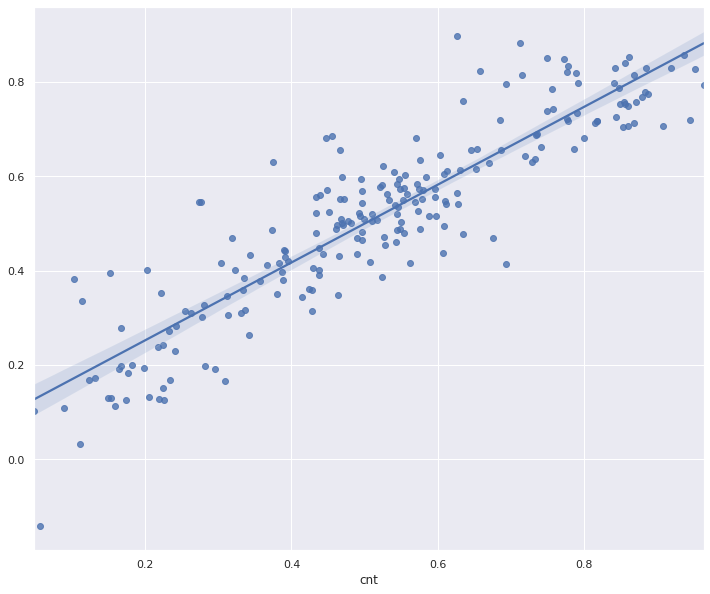

In [47]:
y_pred = lr_4.predict(X_test)
sns.regplot(x=y_test, y=y_pred)

In [48]:
r2_score(y_test, y_pred)

0.8078293916720533

#### The best fitted line appears to be
$ count = 0.1870 + yr \times 0.2334 + workingday \times 0.0547 + temp \times 0.5242 + windspeed \times -0.1552 + spring \times -0.1117 + winter \times 0.0398 + August \times -0.0576 + July \times -0.1126 + June \times -0.0421 + Saturday \times 0.0686 + Light Snow/ Rainy \times -0.2900 + Mist/Cloudy \times -0.0824 $

### The Training R^2 value is 0.838
### The Test R^2 value is 0.808

# The End

## Extra

Selecting 3 features basedon the coefs

In [49]:
X_3 = X_train[['yr','temp','Light Snow/ Rainy']]
X_3 = sm.add_constant(X_3)

lr_top_3 = sm.OLS(y_train, X_3).fit()
lr_top_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     434.7
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          1.39e-139
Time:                        19:15:21   Log-Likelihood:                 363.51
No. Observations:                 510   AIC:                            -719.0
Df Residuals:                     506   BIC:                            -702.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0915      0.014      6.400      0.000       0.063       0.120
yr                    0.2327      0.011     21.897      0.000       0.212       0.254
temp                  0.5784      0.024     24.590      0.000       0.532       0.625
Light Snow/ Rainy    -0.2312      0.031     -7.390      0.000      -0.293      -0.170
==============================================================================
Omnibus:                       10.190   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.295
Skew:                          -0.315   Prob(JB):                      0.00581
Kurtosis:                       3.297   Cond. No.                         7.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Creating line expression programmatically

In [50]:
lr_4.params

const                0.186971
yr                   0.233361
workingday           0.054681
temp                 0.524170
windspeed           -0.155164
spring              -0.111668
winter               0.039761
August              -0.057576
July                -0.112644
June                -0.042110
Saturday             0.068630
Light Snow/ Rainy   -0.290024
Mist/Cloudy         -0.082376
dtype: float64

In [51]:
eq_list=[]
for x in lr_4.params.index:
    eq_list.append(f'{x} \times {lr_4.params[x]:.4f}')

In [52]:
'$ count = '+' + '.join(eq_list)+' $'

'$ count = const \times 0.1870 + yr \times 0.2334 + workingday \times 0.0547 + temp \times 0.5242 + windspeed \times -0.1552 + spring \times -0.1117 + winter \times 0.0398 + August \times -0.0576 + July \times -0.1126 + June \times -0.0421 + Saturday \times 0.0686 + Light Snow/ Rainy \times -0.2900 + Mist/Cloudy \times -0.0824 $'

## Dataset observations

During the data exploration some error was noticed.


If the dteday is interpreted as date and the provided features (e.g.: working day, holiday, day of the week) are extracted from the date, they don't seem to match.

In [53]:
df=pd.read_csv('day.csv')

In [54]:
df['dateday']=pd.to_datetime(df.dteday,dayfirst=True)

In [55]:
df['day_of_week'] = df.dateday.dt.day_of_week
(df['weekday']==df['day_of_week']).sum()

306

This is probably because pandas date starts from Monday, where our data is started from Sunday.
Then again if that is the case the value shouldn't match for some of the rows.

#### 2018 holiday

In [56]:
df[(df['holiday']==1) & (df['yr']==0)].groupby('dteday')['instant'].count()

dteday
04-07-2018    1
05-09-2018    1
10-10-2018    1
11-11-2018    1
15-04-2018    1
17-01-2018    1
21-02-2018    1
24-11-2018    1
26-12-2018    1
30-05-2018    1
Name: instant, dtype: int64

#### 2019 holiday

In [57]:
df[(df['holiday']==1) & (df['yr']==1)].groupby('dteday')['instant'].count()

dteday
02-01-2019    1
03-09-2019    1
04-07-2019    1
08-10-2019    1
12-11-2019    1
16-01-2019    1
16-04-2019    1
20-02-2019    1
22-11-2019    1
25-12-2019    1
28-05-2019    1
Name: instant, dtype: int64

In data dictionary it is mentioned that the holiday list is pick from here
http://dchr.dc.gov/page/holiday-schedule
It points to holiday list of 2021
We can find the holiday list of 2018 & 2019 from
- 2018 : https://dchr.dc.gov/page/holiday-schedules-2018
- 2019 : https://dchr.sp.dc.gov/policy/PCA/EDPM/Issuances/Public%20Holidays%202019.pdf (Page no: 4)
They don't match completely.